Los datos que usará google colab. La información está en:

1. new_base_dir almacena el path de la BD reducida con la que se entrenará en este ejemplo. Dentro debe tener tres carpetas: train, test y validation y dentro de cada una, dos carpetas: Manga y Comic


In [ ]:
!pip install gdown #Instala una librería para descargar archivos de Google Drive
#https://drive.google.com/file/d/1Bj80lhp2N_tzoMMHVaRBdSYToI7t0Poh/view?usp=sharing
!gdown --id 1Bj80lhp2N_tzoMMHVaRBdSYToI7t0Poh #Descarga el daataset que está en el Drive del Prof. Toro
!unzip manga_comic.zip #Descomprime el archivo del dataset
from IPython.display import Image #Librería para visualizar imágenes en Jupyter
new_base_dir=r"manga_comic"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Bj80lhp2N_tzoMMHVaRBdSYToI7t0Poh
To: /content/manga_comic.zip
100% 396M/396M [00:01<00:00, 219MB/s]
Archive:  manga_comic.zip
replace manga_comic/test/Comic/3000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Visualizar una imagen

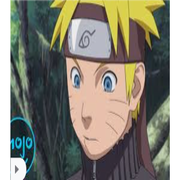

In [ ]:
display(Image(filename="manga_comic/train/Manga/1050.png"))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Definición de la red neuronal de 1 neurona para imagénes de 180x180 píxeles

In [ ]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, SimpleRNN

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_44 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_26  (None, 180, 180, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_26 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 rescaling_30 (Rescaling)    (None, 5, 5, 512)         0  

Hiperparámetros para el entrenamiento y medición de desempeño

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

Convierte la información de la imagen de píxeles en un tensor numérico de punto flotante y ajusta el tamaño de la imagen porque todas tienen diferente resolución

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 3942 files belonging to 2 classes.
Found 1990 files belonging to 2 classes.
Found 2649 files belonging to 2 classes.


Extrayendo las características de los conjuntos de entrenamiento, validación y prueba con sus etiquetas

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        all_features.append(images)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

print(test_features.shape)
print(test_labels.shape)

(2649, 180, 180, 3)
(2649,)


Fase de entrenamiento 

In [ ]:
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset
    )

Epoch 1/15
124/124 [==============================] - 25s 188ms/step - loss: 0.6093 - accuracy: 0.7022 - val_loss: 0.4072 - val_accuracy: 0.8613
Epoch 2/15
124/124 [==============================] - 24s 187ms/step - loss: 0.3720 - accuracy: 0.8564 - val_loss: 0.2826 - val_accuracy: 0.8889
Epoch 3/15
124/124 [==============================] - 24s 187ms/step - loss: 0.3254 - accuracy: 0.8711 - val_loss: 0.2880 - val_accuracy: 0.8714
Epoch 4/15
124/124 [==============================] - 24s 189ms/step - loss: 0.2998 - accuracy: 0.8787 - val_loss: 0.2520 - val_accuracy: 0.8935
Epoch 5/15
124/124 [==============================] - 24s 193ms/step - loss: 0.2832 - accuracy: 0.8856 - val_loss: 0.2448 - val_accuracy: 0.8990
Epoch 6/15
124/124 [==============================] - 24s 188ms/step - loss: 0.2650 - accuracy: 0.8985 - val_loss: 0.2493 - val_accuracy: 0.8980
Epoch 7/15
124/124 [==============================] - 24s 191ms/step - loss: 0.2552 - accuracy: 0.8993 - val_loss: 0.2860 - val_ac

Visualización de la pérdidad y el accuracy tanto para los datos de entrenamiento como para los datos de validación y así detectar si hay overfitting

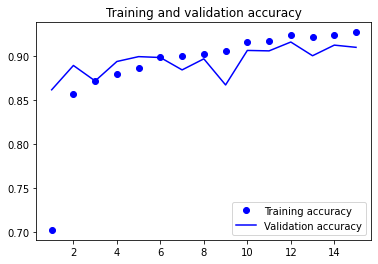

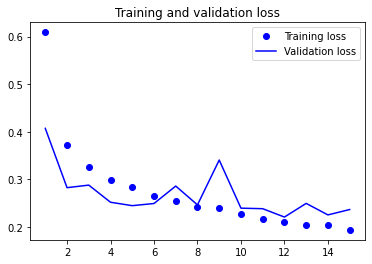

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Matriz de confusión

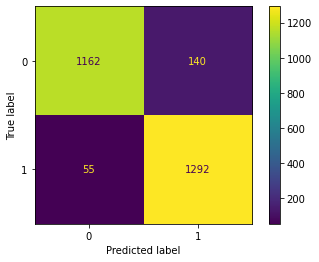

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_predictions = model.predict(test_features)
cm = confusion_matrix(test_labels, test_predictions > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Cálculo de la exactitud (en inglés, *accurracy*)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, test_predictions > 0.5))

0.9263873159682899


Ejercicio:
----------
1. Desarrollar un modelo que tenga la mejor exactitud (en inglés, *accurracy*) posible en el conjunto de prueba (en inglés, *test*). Para lograrlo, hay que hacer un entrenamiento sin sobreajustar (en inglés, *overfit*)